## This file contains the Code to augment the EEG data, based on the EEG Inception paper

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [10]:
def plot_eeg(data):
    """
    Plot EEG signals from multiple channels
    """
    
    n_channels, n_samples = data.shape
    
    # Create time array
    time = np.arange(n_samples)
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2*n_channels))
    fig.suptitle('EEG Signals by Channel', fontsize=16)
    
    # Plot each channel
    for i in range(n_channels):
        axes[i].plot(time, data[i, :], 'b-', linewidth=0.5)
        axes[i].set_ylabel(f'Channel {i+1}')
        axes[i].grid(True)
        
        # Only show x-axis label for the bottom plot
        if i == n_channels-1:
            axes[i].set_xlabel('Samples')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for suptitle
    
    return fig


In [4]:

def butter_highpass(cutoff, fs, order=8):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# This function stores the signals frequency after 100 hz, used for augmenting
def highpass_filter(data, cutoff, fs, order=8):
    b, a = butter_highpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)

def data_augmentation(original_signal, trial_signal, fs = 1000):

    # Step 1: Filter out the noise candidates (frequencies above 100 Hz)
    cutoff = 100  # Cut-off frequency
    noise_candidates = highpass_filter(original_signal, cutoff, fs)

    # Step 2: Clean the original signal
    cleaned_signal1 = original_signal - noise_candidates

    # Step 3: Augment the cleaned signal with noise from another trial
    augmented_signal = cleaned_signal1 + highpass_filter(trial_signal, cutoff, fs)

    return augmented_signal, highpass_filter(original_signal, cutoff, fs), cleaned_signal1


In [13]:
# Sanity
fs = 1000  # Sampling frequency in Hz
t = np.linspace(0, 1, fs)  # 1 second of data
original_signal = np.load('./data/pre-processed_raw/data02_all/data02_4.npy', allow_pickle= 1)
trial_signal = np.load('./data/pre-processed_raw/data02_all/data02_9.npy', allow_pickle= 1)

augmented_signal, noise, _ = data_augmentation(original_signal,trial_signal, fs)

# checking the augmented signal
print(augmented_signal)

[[-34244.743322513576 -34245.259318205266 -34245.62853014278 ...
  -34217.88211978879 -34220.86286270681 -34224.350075449634]
 [-24575.07633701751 -24573.89098558581 -24576.00290345748 ...
  -24556.53894460861 -24560.36089548693 -24562.241751455418]
 [-8200.292958812182 -8200.75309137416 -8202.894030024716 ...
  -8186.327655166069 -8190.06389591005 -8195.373045860779]
 ...
 [-40228.654172780945 -40227.40890094146 -40230.59971024117 ...
  -40206.33710112297 -40212.70491456119 -40218.93949735005]
 [-13766.25786648461 -13764.19702579704 -13767.048129157272 ...
  -13753.813488742375 -13760.126729727577 -13766.699398602997]
 [-760.3125631224123 -757.7306927512346 -759.8024905510383 ...
  -743.4237874863904 -751.0335933068391 -757.2870805312217]]


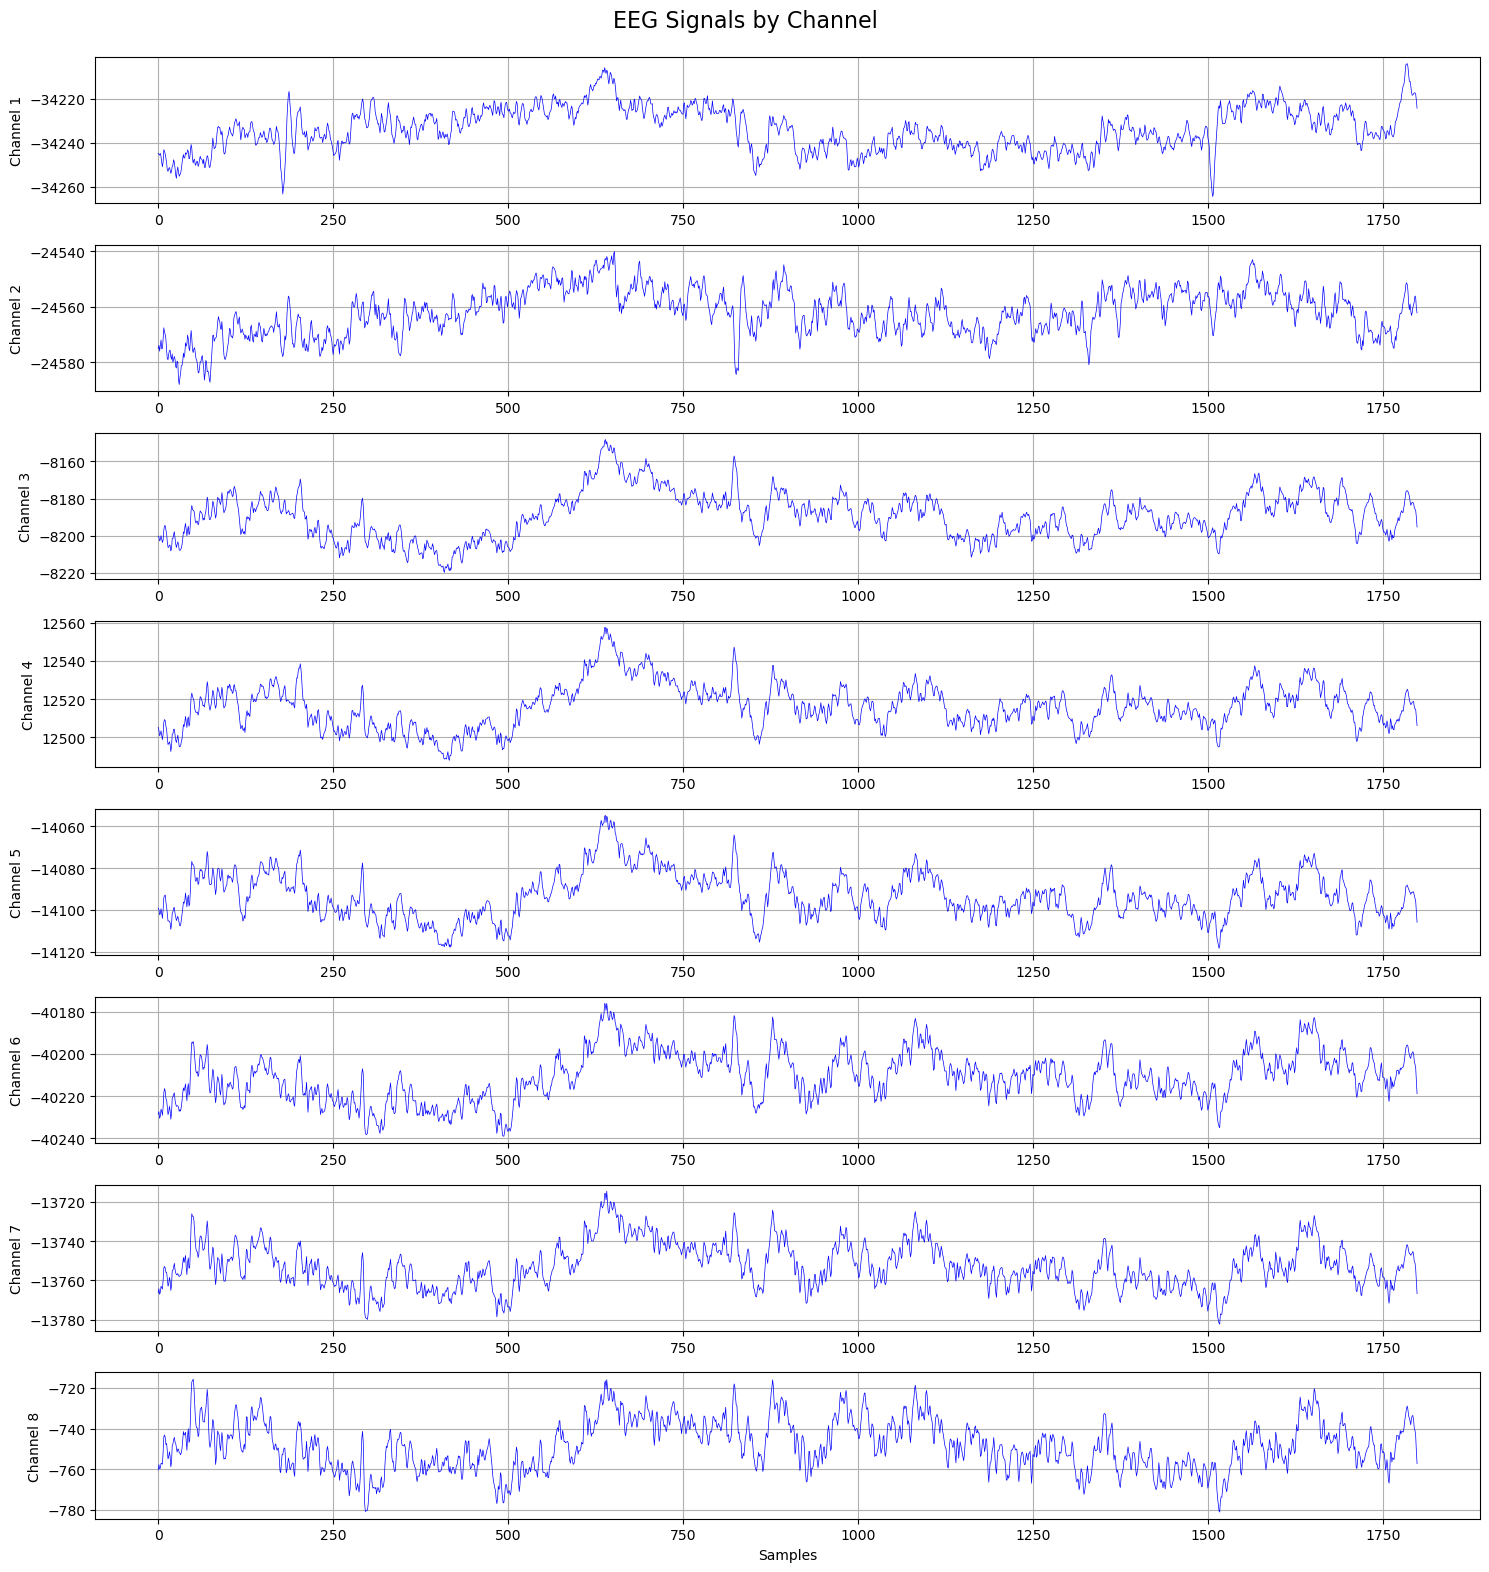

In [ ]:
# printing the augmented signal
plt.close()
plot_eeg(augmented_signal)
plt.show()

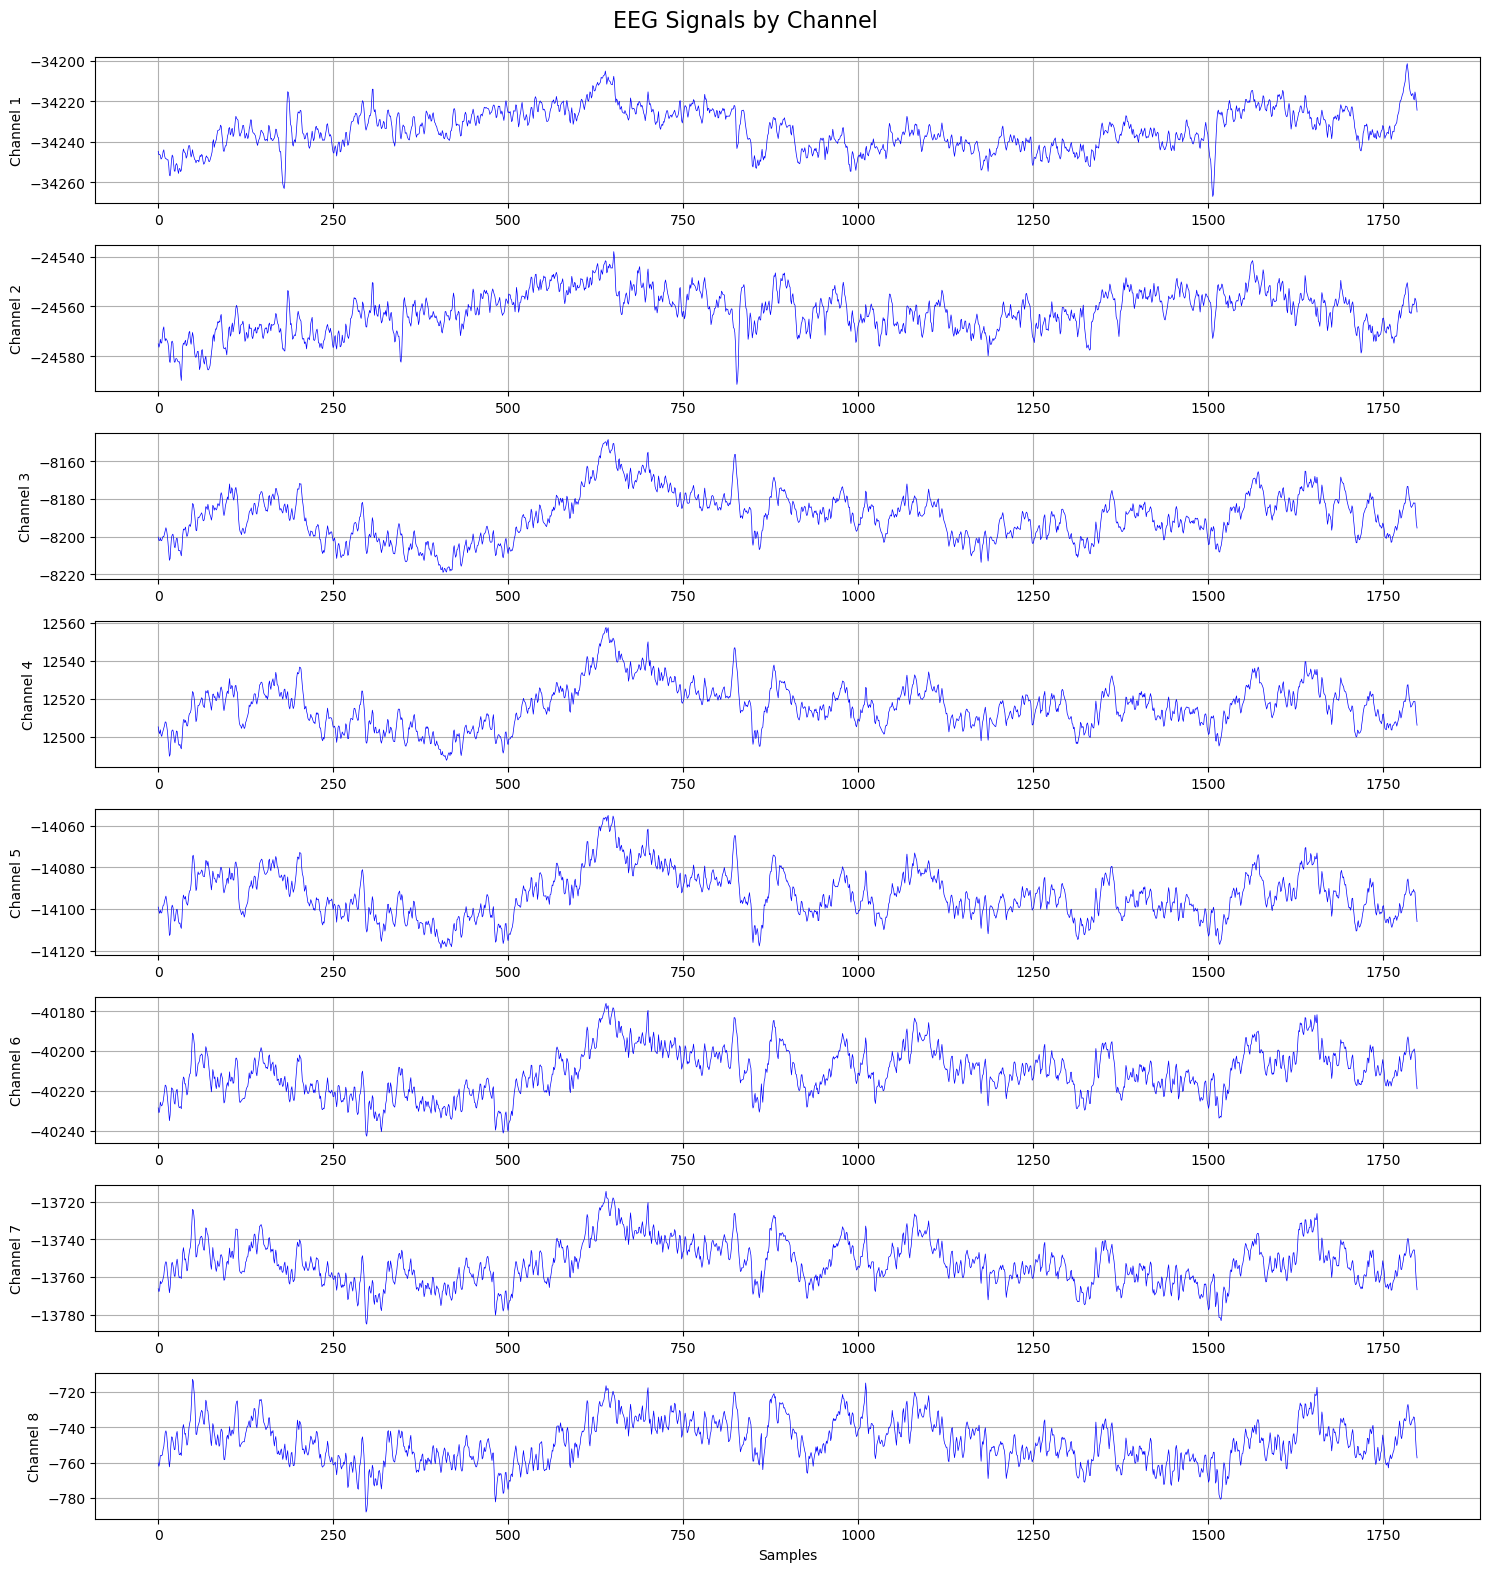

In [15]:
plt.close()
plot_eeg(original_signal)
plt.show()

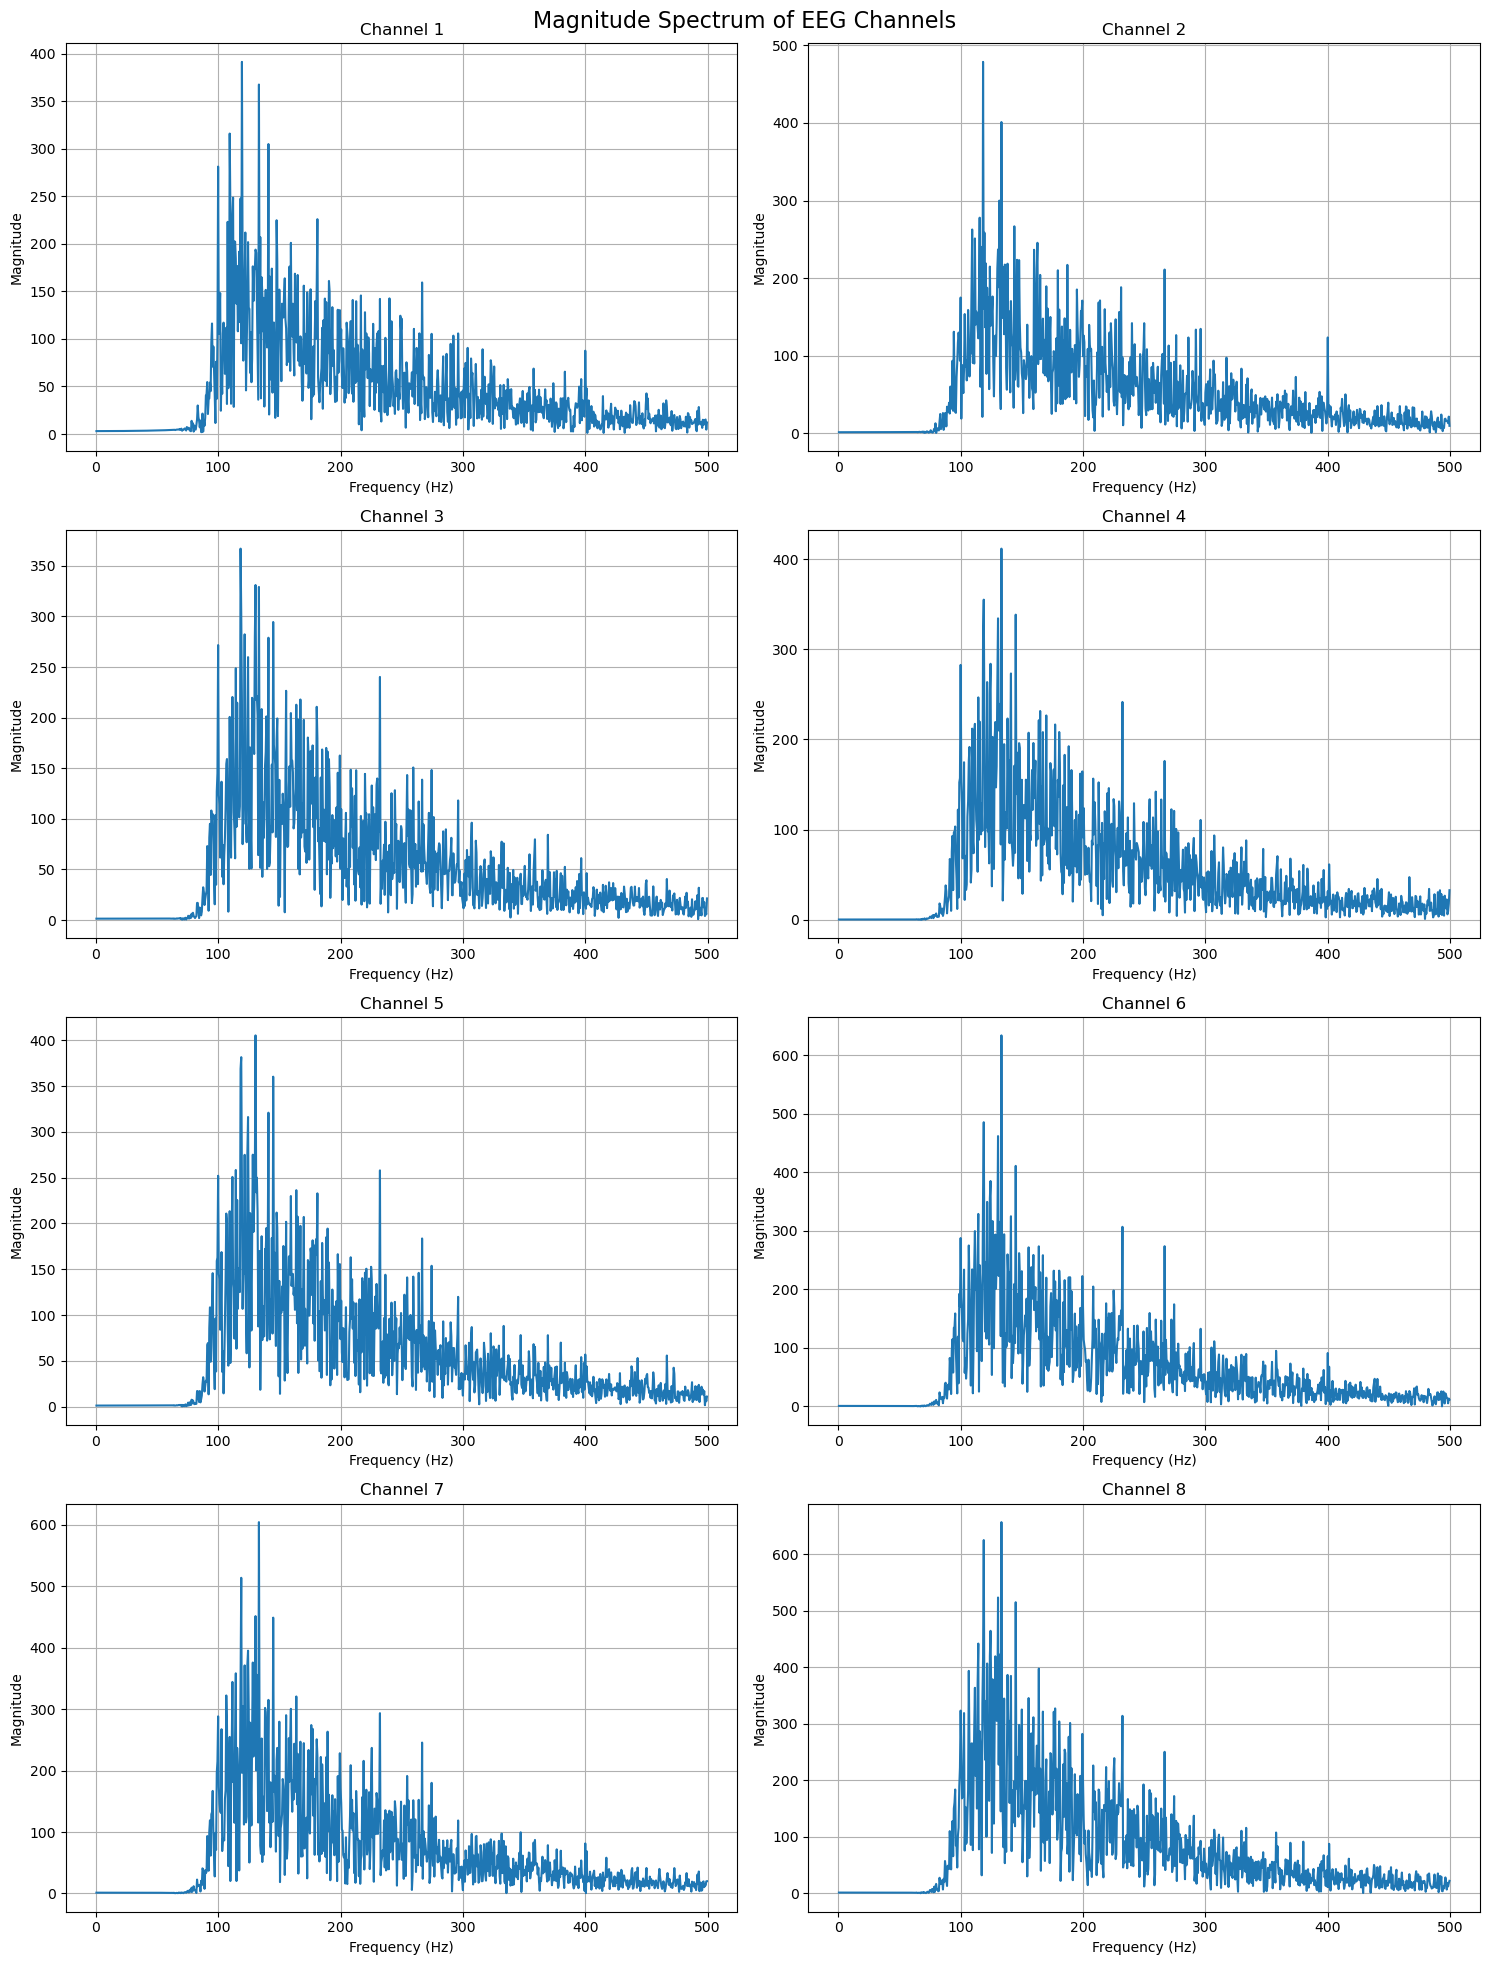

In [ ]:
# printing the noise in frequency domain 
def plot_channel_spectrum(signal_data, sampling_rate=1000, n_channels=8):
    
    # Create figure with subplots
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    fig.suptitle('Magnitude Spectrum of EEG Channels', fontsize=16)
    
    # Flatten axs for easier iteration
    axs = axs.flatten()
    
    # Load and process each channel
    for ch in range(n_channels):
        # Extract channel data
        signal = signal_data[ch, :]
        
        # Apply FFT
        fourier = np.fft.fft(signal)
        n = len(signal)
        frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
        
        default = 1
        # Take only the positive half of the spectrum
        positive_frequencies = frequencies[default:n//2]
        positive_spectrum = np.abs(fourier[default:n//2])
        
    
        # Plot in corresponding subplot
        axs[ch].plot(positive_frequencies, positive_spectrum)
        axs[ch].set_xlabel('Frequency (Hz)')
        axs[ch].set_ylabel('Magnitude')
        axs[ch].set_title(f'Channel {ch+1}')
        axs[ch].grid(True)

    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Load the signal data

plot_channel_spectrum(highpass_filter(trial_signal, 100, fs), n_channels=8)

In [69]:
"""I have two datasets that I will combine. After merging them, I will segregate the data into positive and negative values. This will allow me to augment the 
positive values with other positive values, and the negative values with other negative values."""

df1 = pd.read_csv("./data/pre-processed_raw/data02_all/data02.csv")
df2 = pd.read_csv("./data/pre-processed_raw/data03_all/data03.csv")

df1["annotations"].replace({"Absent": 0, "Present": 1}, inplace=True)

df = pd.concat((df1, df2), axis=0).reset_index(drop=True)


In [70]:
# seggregating the positive and negative samples from the dataset

ones = df[df["annotations"]== 1]
zeroes = df[df["annotations"] == 0]

print(f"The number of positive samples are {len(ones)} and negative samples are {len(zeroes)}")

The number of positive samples are 3384 and negative samples are 7406


In [71]:
from collections import defaultdict
import random

# function to get the random samples except itself.
def get_samples(k = 4, l = 10):
    """
    k: number of samples to get
    l: range of the samples"""

    ref = defaultdict(lambda : [])
    for i in l:
        n = k
        while n:
            r = random.sample(l, 1)
            if r != i and r not in ref[i]:
                n-=1
                # returns list, but take first element
                ref[i].append(r[0])
    return ref

# calculations to balance the sampling 
ones_to_get = len(ones) * 3
zeroes_to_get = len(ones) * 4 - len(zeroes)

# ones_ref and zeroes_ref are dictionaries that store samples, each of the values are unique, excluding themselves.
ones_ref = get_samples(l = range(len(ones)), k = 3)
zeroes_ref = get_samples(l = random.sample(range(len(zeroes)), zeroes_to_get), k = 1)

print(f"generating {ones_to_get} augmented positive samples and {zeroes_to_get} augmented negative samples")


generating 10152 augmented positive samples and 6130 augmented negative samples


In [ ]:
print(zeroes_ref)

In [ ]:
import os 

def augment_and_store(df, ref = ones_ref, path = "ones"):

    # chatgpt
    # Define the directory path
    directory_path = "./data/pre-processed_raw/augmented_data/" + path
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)

    # keep track of the index
    counter = 0

    for key, values in ref.items():
        # iterate through k values 
        for value in values:
            
            original_signal = np.load(df.iloc[key]["paths"], allow_pickle= True)
            reference_signal = np.load(df.iloc[value]["paths"], allow_pickle= True)
            signal= data_augmentation(original_signal, reference_signal)
            
            target = directory_path + f"/{str(counter)}.npy"
            
            np.save(target, signal[0])
            counter += 1
        


if __name__ == "__main__":
    augment_and_store(ref = ones_ref, path= "ones",df = ones)
    augment_and_store(ref = zeroes_ref, path = "zeroes",df = zeroes)

In [ ]:
def get_csvfile_for_samples(path):

    data = f".\\data\\pre-processed_raw\\augmented_data\\{path}\\"

    paths = []

    for i in os.listdir(data):
        paths.append(data + i)

    print(paths)
    if paths == "ones":
        vals = [1] * len(paths)
    else:
        vals = [0] * len(paths)

    r = {"paths" : paths, "annotations" : vals}
    r = pd.DataFrame(r)
    r.to_csv(data + f"/{path}.csv")

get_csvfile_for_samples("zeroes")
get_csvfile_for_samples("ones")
